In [81]:
import numpy as np
import pandas as pd

from pprint import pprint

from decision_tree_functions import train_test_split,decision_tree_algorithm, make_predictions, calculate_accuracy

# 1. Post-Pruning

In [82]:
def filter_df(df, question):
    feature, comparison_operator, value = question.split()
    
    # continuous feature
    if comparison_operator == "<=":
        df_yes = df[df[feature] <= float(value)]
        df_no =  df[df[feature] >  float(value)]
        
    # categorical feature
    else:
        df_yes = df[df[feature].astype(str) == value]
        df_no  = df[df[feature].astype(str) != value]
    
    return df_yes, df_no

In [83]:
def determine_leaf(df_train, ml_task):
    
    if ml_task == "regression":
        return df_train.label.mean()
    
    # classification
    else:
        return df_train.label.value_counts().index[0]

In [84]:
def determine_errors(df_val, tree, ml_task):
    predictions = make_predictions(df_val, tree)
    actual_values = df_val.label
    
    if ml_task == "regression":
        # mean squared error
        return ((predictions - actual_values) **2).mean()
    else:
        # number of errors
        return sum(predictions != actual_values)

In [85]:
def pruning_result(tree, df_train, df_val, ml_task):
    
    leaf = determine_leaf(df_train, ml_task)
    errors_leaf = determine_errors(df_val, leaf, ml_task)
    errors_decision_node = determine_errors(df_val, tree, ml_task)

    if errors_leaf <= errors_decision_node:
        return leaf
    else:
        return tree

In [86]:
def post_pruning(tree, df_train, df_val, ml_task):
    
    question = list(tree.keys())[0]
    yes_answer, no_answer = tree[question]

    # base case
    if not isinstance(yes_answer, dict) and not isinstance(no_answer, dict):
        return pruning_result(tree, df_train, df_val, ml_task)
        
    # recursive part
    else:
        df_train_yes, df_train_no = filter_df(df_train, question)
        df_val_yes, df_val_no = filter_df(df_val, question)
        
        if isinstance(yes_answer, dict):
            yes_answer = post_pruning(yes_answer, df_train_yes, df_val_yes, ml_task)
            
        if isinstance(no_answer, dict):
            no_answer = post_pruning(no_answer, df_train_no, df_val_no, ml_task)
        
        tree = {question: [yes_answer, no_answer]}
    
        return pruning_result(tree, df_train, df_val, ml_task)

# 2.Iris Data Set

In [87]:
df = pd.read_csv('iris.csv')
df.rename(columns = {'target': 'label', 'sepal length (cm)': 'sl', 'sepal width (cm)': 'sw', 'petal length (cm)': 'pl', 'petal width (cm)': 'pw'}, inplace = True)

In [88]:
df

,sl,sw,pl,pw,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [89]:
metrics = {"max_depth": [], "acc_tree": [], "acc_tree_pruned": []}
for n in range(10, 26):
    df_train, df_test = train_test_split(df, test_size=0.15)
    df_train, df_val = train_test_split(df_train, test_size=0.15)

    tree = decision_tree_algorithm(df_train, ml_task="classification", max_depth=n)
    tree_pruned = post_pruning(tree, df_train, df_val, ml_task="classification")
    
    metrics["max_depth"].append(n)
    metrics["acc_tree"].append(calculate_accuracy(df_test, tree))
    metrics["acc_tree_pruned"].append(calculate_accuracy(df_test, tree_pruned))
    
df_metrics = pd.DataFrame(metrics)
df_metrics = df_metrics.set_index("max_depth")

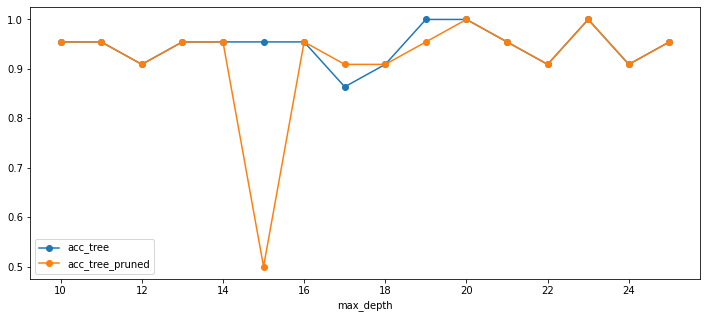

In [90]:
df_metrics.plot(figsize=(12, 5), marker="o")